# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import cv2
import matplotlib
import numpy
import PIL
import torch
import torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [46]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets
import torch as torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

train_data_location='/data/landmark_images/train'
test_data_location='/data/landmark_images/test'


batch_size=10
num_workers = 0
valid_size = 0.2

transform = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform1 = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_d = datasets.ImageFolder(train_data_location, transform=transform)
test_d = datasets.ImageFolder(test_data_location, transform=transform1)

# obtain training indices that will be used for validation
num_train = len(train_d)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
trainloader = torch.utils.data.DataLoader(train_d,
                   sampler=train_sampler, batch_size=batch_size,num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_d,
                   sampler=valid_sampler, batch_size=batch_size,num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_d,
                   batch_size=batch_size,num_workers=num_workers)


loaders_scratch = {'train': trainloader, 'valid': validloader, 'test': testloader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: *The images were resized to 256 and center cropped to give padding horizontally and vertically
            Then ,it was converted to a tensor and normalised to get pixel values in a range of [-1,1].
            *The data was augmented in the first trial but gave lesser accuracy than not being flipped or rotated so, I removed those parameters for this one. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [8]:
train_d.classes

['00.Haleakala_National_Park',
 '01.Mount_Rainier_National_Park',
 '02.Ljubljana_Castle',
 '03.Dead_Sea',
 '04.Wroclaws_Dwarves',
 '05.London_Olympic_Stadium',
 '06.Niagara_Falls',
 '07.Stonehenge',
 '08.Grand_Canyon',
 '09.Golden_Gate_Bridge',
 '10.Edinburgh_Castle',
 '11.Mount_Rushmore_National_Memorial',
 '12.Kantanagar_Temple',
 '13.Yellowstone_National_Park',
 '14.Terminal_Tower',
 '15.Central_Park',
 '16.Eiffel_Tower',
 '17.Changdeokgung',
 '18.Delicate_Arch',
 '19.Vienna_City_Hall',
 '20.Matterhorn',
 '21.Taj_Mahal',
 '22.Moscow_Raceway',
 '23.Externsteine',
 '24.Soreq_Cave',
 '25.Banff_National_Park',
 '26.Pont_du_Gard',
 '27.Seattle_Japanese_Garden',
 '28.Sydney_Harbour_Bridge',
 '29.Petronas_Towers',
 '30.Brooklyn_Bridge',
 '31.Washington_Monument',
 '32.Hanging_Temple',
 '33.Sydney_Opera_House',
 '34.Great_Barrier_Reef',
 '35.Monumento_a_la_Revolucion',
 '36.Badlands_National_Park',
 '37.Atomium',
 '38.Forth_Bridge',
 '39.Gateway_of_India',
 '40.Stockholm_City_Hall',
 '41.Ma

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  #to tensor image

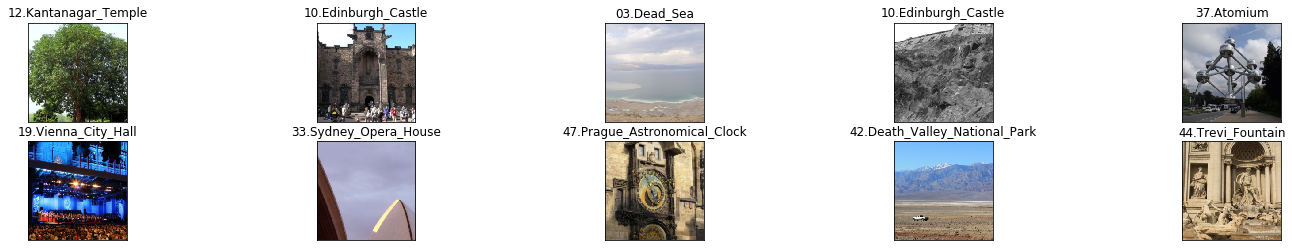

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

#dataiter = next(iter(loaders_scratch['train']))
images,labels = next(iter(loaders_scratch['train']))
class_index=labels.tolist()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_d.classes[class_index[idx]])


### Initialize use_cuda variable

In [8]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [51]:
import torch.nn as nn

In [52]:
## TODO: select loss function
import torch.optim as optim
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(),lr=0.012)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [53]:
import torch.nn as nn
import torch.nn.functional as F


# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1= nn.Conv2d(3,16,3,padding=1)
        self.conv2= nn.Conv2d(16,64,3,padding=1)
        self.conv3= nn.Conv2d(64,256,5,padding=1)
        self.conv4= nn.Conv2d(256,1024,5,padding=1)
        #self.conv5= nn.COnv2

        #pooling layers 
        self.pool=nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)
        
        self.fc1=nn.Linear(1024*12*12,512)
        self.fc2=nn.Linear(512,512)
        self.fc3=nn.Linear(512,50)

    
    def forward(self, x):
        ## Define forward behavior
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        x=self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        #x=x.view(-1,256*37*37)
        x=x.view(-1,1024*12*12)
      #  print(x.shape)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        x=F.relu(self.fc3(x))
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  As the features to be extracted were varying and had no similarity with each other, I made sure to have enough layers in the CNN to extract about 1024 layers of patterns ato help the model train better and also the kernel size was left at 3 initially to extract smaller minute features and then later on extended to 5 to extract biggger features.
Also after each layer, the maxpool layers reduce the x and y dimensions of the image to help reduce the input nodes before putting it through the linear layers. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [54]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output=model(data)
            loss= criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - train_loss)) 
            
        
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output=model(data)
            loss=criterion(output,target)
            valid_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss)) 



        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        
        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased from({:.6f} --> {:.6f}).  Save this model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [56]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(2)

    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 880.089453 	Validation Loss: 6.122333
Validation loss decreased from(inf --> 6.122333).  Save this model ...
Epoch: 2 	Training Loss: 4.764632 	Validation Loss: 4.312691
Validation loss decreased from(6.122333 --> 4.312691).  Save this model ...
Epoch: 3 	Training Loss: 4.130158 	Validation Loss: 4.015070
Validation loss decreased from(4.312691 --> 4.015070).  Save this model ...
Epoch: 4 	Training Loss: 3.937827 	Validation Loss: 3.921253
Validation loss decreased from(4.015070 --> 3.921253).  Save this model ...
Epoch: 5 	Training Loss: 3.922238 	Validation Loss: 3.919705
Validation loss decreased from(3.921253 --> 3.919705).  Save this model ...
Epoch: 6 	Training Loss: 3.920363 	Validation Loss: 3.919106
Validation loss decreased from(3.919705 --> 3.919106).  Save this model ...
Epoch: 7 	Training Loss: 3.918984 	Validation Loss: 3.918566
Validation loss decreased from(3.919106 --> 3.918566).  Save this model ...
Epoch: 8 	Training Loss: 3.917712 	Validatio

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [57]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20 # at 17 the loss started saturating during the previous run 

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


Epoch: 1 	Training Loss: 3.911433 	Validation Loss: 3.910820
Validation loss decreased from(inf --> 3.910820).  Save this model ...
Epoch: 2 	Training Loss: 3.906340 	Validation Loss: 3.897883
Validation loss decreased from(3.910820 --> 3.897883).  Save this model ...
Epoch: 3 	Training Loss: 3.867427 	Validation Loss: 3.811440
Validation loss decreased from(3.897883 --> 3.811440).  Save this model ...
Epoch: 4 	Training Loss: 3.806975 	Validation Loss: 3.751373
Validation loss decreased from(3.811440 --> 3.751373).  Save this model ...
Epoch: 5 	Training Loss: 3.752787 	Validation Loss: 3.749331
Validation loss decreased from(3.751373 --> 3.749331).  Save this model ...
Epoch: 6 	Training Loss: 3.689015 	Validation Loss: 3.648356
Validation loss decreased from(3.749331 --> 3.648356).  Save this model ...
Epoch: 7 	Training Loss: 3.611361 	Validation Loss: 3.634165
Validation loss decreased from(3.648356 --> 3.634165).  Save this model ...
Epoch: 8 	Training Loss: 3.518231 	Validation 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [58]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.208069


Test Accuracy: 22% (283/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [59]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

from torchvision import datasets
import torch as torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

train_data_location='/data/landmark_images/train'
test_data_location='/data/landmark_images/test'


batch_size=10
num_workers = 0
valid_size = 0.2

transform = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform1 = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_d = datasets.ImageFolder(train_data_location, transform=transform)
test_d = datasets.ImageFolder(test_data_location, transform=transform1)

# obtain training indices that will be used for validation
num_train = len(train_d)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
trainloader = torch.utils.data.DataLoader(train_d,
                   sampler=train_sampler, batch_size=batch_size,num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_d,
                   sampler=valid_sampler, batch_size=batch_size,num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_d,
                   batch_size=batch_size,num_workers=num_workers)


loaders_transfer = {'train': trainloader, 'valid': validloader, 'test': testloader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [60]:
## TODO: select loss function

## TODO: select loss function
import torch.optim as optim
import torch.nn as nn

criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.parameters(),lr=0.012)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [9]:
## TODO: Specify model architecture

import torchvision
from torchvision import  models

model_transfer = models.vgg16(pretrained=True)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The data was trained earlier on Resnet18 model and was faster than vgg16 and had a deeper architecture.The vgg16 architecture has 16 layers, the convolutional ones to extract much more features alongwith the max pooling between 2-3 layers to keep reducing the dimensionality.
Vgg16 provided better accuracy for this dataset and thus, the choice.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [69]:
def train_new(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output=model(data)
            loss= criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - train_loss)) 
            
        
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output=model(data)
            loss=criterion(output,target)
            valid_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss)) 



        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        
        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased from({:.6f} --> {:.6f}).  Save this model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
        
        
    return model

In [71]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'


model_transfer = train_new(10, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.063119 	Validation Loss: 1.538138
Validation loss decreased from(inf --> 1.538138).  Save this model ...
Epoch: 2 	Training Loss: 0.682035 	Validation Loss: 1.302099
Validation loss decreased from(1.538138 --> 1.302099).  Save this model ...
Epoch: 3 	Training Loss: 0.454829 	Validation Loss: 1.531105
Epoch: 4 	Training Loss: 0.349080 	Validation Loss: 2.562590
Epoch: 5 	Training Loss: 0.261827 	Validation Loss: 1.424319
Epoch: 6 	Training Loss: 0.196729 	Validation Loss: 1.621240
Epoch: 7 	Training Loss: 0.135144 	Validation Loss: 1.553198
Epoch: 8 	Training Loss: 0.089824 	Validation Loss: 1.667052
Epoch: 9 	Training Loss: 0.126806 	Validation Loss: 1.758399
Epoch: 10 	Training Loss: 0.069131 	Validation Loss: 1.627347


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [72]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.125915


Test Accuracy: 71% (897/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [10]:
from torchvision import datasets
import torchvision.transforms as transforms

train_data_location='/data/landmark_images/train'

transform = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_d = datasets.ImageFolder(train_data_location, transform=transform)

In [11]:
import torch as torch

import cv2
from PIL import Image

model_transfer.load_state_dict(torch.load('model_transfer.pt'))
model_transfer.eval()
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN 
    img = Image.open(img_path)
    transform_test = transforms.Compose([transforms.Resize((256)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    
    img_tr = transform_test(img)
    img_tr.unsqueeze_(0)
    img_tr = img_tr.to('cuda')
    prediction = model_transfer(img_tr)
   # prediction = prediction.cpu().data.numpy().argmax() # prediction will be the index of the class label with the largest value.
    #print(labels[prediction]) 
    prediction = prediction.cpu().data
    _,indices=torch.topk(prediction, k)
   
    #print(train_d.classes[prediction])
    #output = model_transfer(img_tr)
    #print(output) #print output from crossentropy score

    #sm = torch.nn.Softmax()
    #probabilities = sm(output) 
    #print(probabilities)
    locations=[]
    for i in range(0,k):
        location=train_d.classes[indices[0][i]]
        location=location.replace("_"," ")
        locations.append(location[3:])
        
    return locations


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Brooklyn Bridge',
 'Forth Bridge',
 'Niagara Falls',
 'Dead Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the
Golden Gate Bridge , Brooklyn Bridge , Forth Bridge , ?


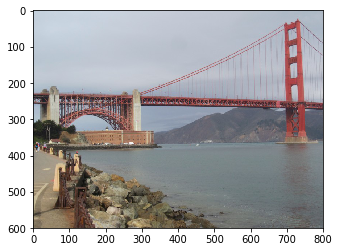

In [12]:
from matplotlib.pyplot import imshow
import numpy as np
%matplotlib inline
def suggest_locations(img_path):

    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)

    ## TODO: display image and display landmark predictions
    pil_im = Image.open(img_path, 'r')
    imshow(np.asarray(pil_im))
    
    print("Is this picture of the")
    for i in (predicted_landmarks):
            print(i,", ",end="")      
    print("?")
 

    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The outputs were pretty good as it predicted the golden gate bridge , Opera House and Great wallof China as the first choice.
Stonehenge was predicted inaccurately.

1) The vgg16 model parameters could be changed like increasing/decresing the kernel sizes.
2) The backpropogation optimizers could be changed as well.
3) The learning rate could be increased/decreased and re-run the model.

Is this picture of the
Stockholm City Hall , Vienna City Hall , Taj Mahal , ?


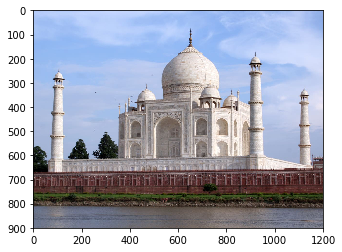

In [13]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.


#image 1
suggest_locations('taj-mahal.jpg')

Is this picture of the
Mount Rushmore National Memorial , Seattle Japanese Garden , Haleakala National Park , ?


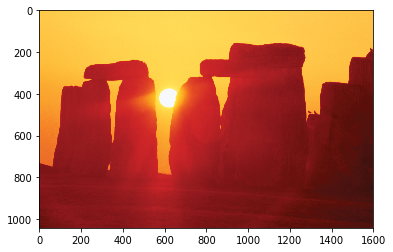

In [14]:
#image 2
suggest_locations('Stonhenge.jpg')

Is this picture of the
Atomium , Prague Astronomical Clock , Eiffel Tower , ?


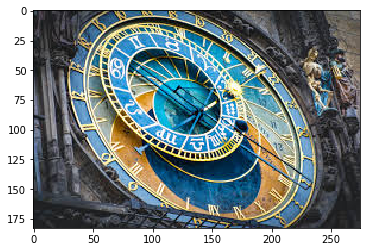

In [15]:
#image 3
suggest_locations('prague clock.jfif')

Is this picture of the
Sydney Opera House , Great Barrier Reef , Niagara Falls , ?


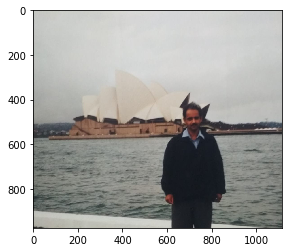

In [17]:
#image 4 ; That's my dad outside Sydney opera house
suggest_locations('WhatsApp Image 2021-07-30 at 21.25.49.jpeg')

Is this picture of the
Great Wall of China , Mount Rainier National Park , Temple of Heaven , ?


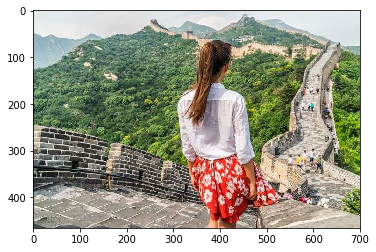

In [16]:
#image 5
suggest_locations('Great-Wall-Of-China-Cover-Img.jpg')